# Machine Learning with scikit-learn

Sometimes the features you have available in your initial data have little predictive strength when used in the most straightforward way.  This might be true almost regardless of choice of model class and hyperparameters.  And yet it might also be true that there are synthetic features latent in the data that are highly predictive, but that have to be *engineered* (mechanically, rather than sample-wise modification) to produce powerful features.

At the same time, a highly dimension model—whether of high dimension because of the initial data collection or because of creation of extra synthetic features—may lend itself less well to modeling techniques.  In these cases, it can be more computationally tractable, as well as more predictive, to work with a subset of all available features.

We will spend several lessons that can be thought of broadly as "Feature Engineering." This middle lesson focuses on creating new composite or derived features features.

In [1]:
%matplotlib inline
from src.setup import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# A synthetic example

Let us look at an artificial example where the raw features of a dataset are of absolutely no value, but it is possible to derive good predictions by creating syntheric features out of them.  Obviously, real world data will not be as neat as that, but it is useful to express the concept.

At first brush the loaded data seems fairly noisy without an obvious pattern.

In [2]:
linf.head()

,feature_1,feature_2,TARGET
0,0.162275,-0.282523,-0.045846
1,-0.874404,-0.164955,0.144237
2,0.000540,0.751708,0.000406
3,0.721775,-0.246271,-0.177752
4,0.374113,0.283637,0.106112


In [3]:
# The features seem uncorrelated, and no univariate correlation with target
linf.corr()

,feature_1,feature_2,TARGET
feature_1,1.000000,-0.006995,0.033990
feature_2,-0.006995,1.000000,-0.031077
TARGET,0.033990,-0.031077,1.000000


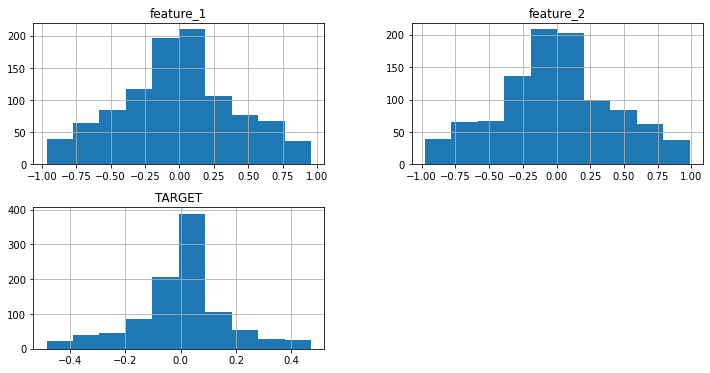

In [4]:
# Distribution of features and target looks roughly Gaussian
linf.hist(figsize=(12,6));

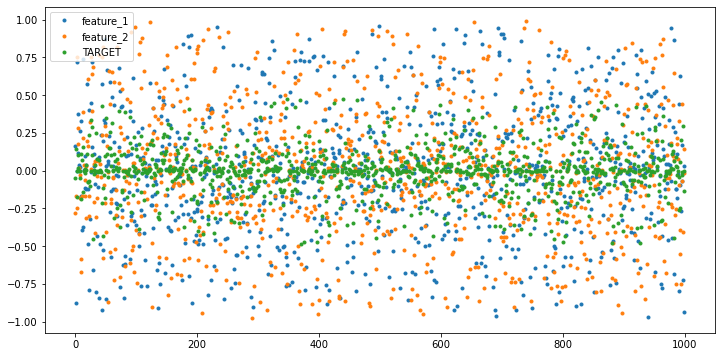

In [5]:
# No obvious trends in the data as sequences
%matplotlib inline
linf.plot(figsize=(12,6), style='.');

We might hope to identify a relationship between features and target using a linear regression such as this:

In [6]:
from sklearn.linear_model import LinearRegression

X = linf.drop('TARGET', axis=1)
y = linf['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

-5.835735708026313e-05

Slightly different linear models do equally poorly in detecting any relationship between the features and the target.  Notice that the metric used here is $R^2$ score rather than e.g. explained variance or mean absolute error (or others).


In [7]:
from sklearn.linear_model import Lasso, Ridge
lasso, ridge = Lasso(), Ridge()
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)

lasso.score(X_test, y_test), ridge.score(X_test, y_test)

(-9.063656883312454e-05, -4.645650274470725e-05)

## Adding a feature

Let us try creating a new feature that is entirely based on existing features.

In [8]:
linf['f1xf2'] = linf.feature_1 * linf.feature_2
linf.head()

,feature_1,feature_2,TARGET,f1xf2
0,0.162275,-0.282523,-0.045846,-0.045846
1,-0.874404,-0.164955,0.144237,0.144237
2,0.000540,0.751708,0.000406,0.000406
3,0.721775,-0.246271,-0.177752,-0.177752
4,0.374113,0.283637,0.106112,0.106112


In [9]:
X = linf.drop('TARGET', axis=1)
y = linf['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

1.0

The information we need was "latent" in the data the whole time, it just needed to be teased out.

In fairness, we can note that other regressors manage to derive the synthetic feature through their algorithmic structure.  But these regressors will have their own "blind spots" also, relative to different datasets.

In [10]:
X = linf.drop('TARGET', axis=1)
y = linf['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr.score(X_test, y_test)

0.9997795709809882

In [12]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

0.9719663005323181

In [13]:
X = linf.drop(['TARGET', 'f1xf2'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr.score(X_test, y_test)

0.9740851297466192

In [14]:
svr = SVR()
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

0.9611645237946982

# Dimensionality Expansion

There are two standard ways in which you are likely to engineer new synthetic features based on existing features: polynomial features and one-hot encoding.  In a sense, the decompositions also do the same thing—but they create synthetic features globally across the parametric space, and they generally are used as replacements rather than supplements to raw features.

## Polynomial Features

Generating polynomial features will create a very large number of new features.  The basic idea is simple, we add new features that are the multiplicative product of up to degree=N of the existing features.  In the toy example at the beginning of this lesson, we manually synthesized one feature by multiplying two existing ones together.  The `PolyFeatures` construction does so with all combinations of parameters.

Often using polynomial features is a large part of the reason it is particularly important to go back and winnow features using feature selection.  Reducing 30 features to 15, for example, is unlikely to be hugely important to most models.  But reducing the 496 synthetic features in the below example becomes important (let alone the much larger number if you choose a higher degree or started with more raw features).  We look at this winnowing in the next lesson.

If the `interactions_only` option is not used, the number of produced features is:

$$ \#Features = N + N + \frac{N \times (N-1)}{2} + 1 $$

E.g. for dimensions=30, it is 496; for dimensions=100, it is 5151.

In [15]:
cancer = load_breast_cancer()

In [16]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(cancer.data)
print(cancer.data.shape)
print(X_poly.shape)

(569, 30)
(569, 496)


In [17]:
poly_names = poly.get_feature_names(cancer.feature_names)
pd.DataFrame(X_poly, columns=poly_names).head()

,1,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst concavity^2,worst concavity worst concave points,worst concavity worst symmetry,worst concavity worst fractal dimension,worst concave points^2,worst concave points worst symmetry,worst concave points worst fractal dimension,worst symmetry^2,worst symmetry worst fractal dimension,worst fractal dimension^2
0,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,0.506802,0.188938,0.327545,0.084645,0.070437,0.122111,0.031556,0.211692,0.054706,0.014137
1,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,0.058371,0.044938,0.066440,0.021507,0.034596,0.051150,0.016558,0.075625,0.024481,0.007925
2,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,0.202860,0.109447,0.162730,0.039446,0.059049,0.087796,0.021282,0.130538,0.031643,0.007670
3,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,0.471832,0.176877,0.455964,0.118834,0.066306,0.170928,0.044547,0.440630,0.114837,0.029929
4,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,0.160000,0.065000,0.094560,0.030712,0.026406,0.038415,0.012477,0.055885,0.018151,0.005895


Just to show it off, let us look at how much more higher degree combinations would explode things.

In [18]:
PolynomialFeatures(3).fit_transform(cancer.data).shape

(569, 5456)

In [19]:
PolynomialFeatures(4).fit_transform(cancer.data).shape

(569, 46376)

Working with 5k, let alone 50k, features is quite unwieldy.  Even 500 is questionable, especially given we only have about the same number of rows here.  But we look at features selection/elimination in the next lesson.

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=7, random_state=1)

We can see that we get significant improvement with polynomial features.  Note that even simple models do "pretty well" with the most naive attempts.  Here it is more illustrative to look at how often a model is *wrong* than its accuracy to highlight differences.

In [21]:
# Scale the engineered features 
# (makes little difference for this model, but is good practice)
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=42)

acc = rfc.fit(X_train, y_train).score(X_test, y_test)
print(f"Error rate: {(1-acc)*100:.2f}%")

Error rate: 2.80%


In [22]:
poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(cancer.data)

# Scale the engineered features 
# (makes little difference for this model, but is good practice)
from sklearn.preprocessing import MinMaxScaler
X_poly_scaled = MinMaxScaler().fit_transform(X_poly)
# makes no difference whether we scale

X_train, X_test, y_train, y_test = train_test_split(
    X_poly_scaled, cancer.target, random_state=42)

acc = rfc.fit(X_train, y_train).score(X_test, y_test)
print(f"Error rate: {(1-acc)*100:.2f}%")

Error rate: 1.40%


## One-Hot Encoding

We have looked in previous lessons at the need to encode categorical values in **one-hot encoding**.  That is, we might have one feature with a number of class values encoded in it.  For many models, this is either better quality—or simply required for the code to operate—than trying to use the class labels.  In some cases, integer values might work algorithmically, but will distort the training by being interpreted in a quantitative or ordinal way.

The interfaces provided by scikit-learn are servicable, but somewhat awkward.  `sklearn.preprocessing.LabelBinarizer` does almost what you want in some cases, but doesn't expose the clearest API.  The same can be said of `sklearn.preprocessing.OneHotEncoder` and `sklearn.preprocessing.LabelEncoder` and a couple others.  I simply recommend using `pandas.get_dummies()` in place of these others.  The result will be the same, in any case.

Let us look at a small toy example with catgorical data.

In [23]:
pets = pd.read_csv('data/pets.csv')
pets

,species,sex
0,cat,M
1,dog,F
2,fish,M
3,dog,M
4,dog,F
5,cat,M
6,fish,M
7,fish,F


In [24]:
pd.get_dummies(pets, dummy_na=True)

,species_cat,species_dog,species_fish,species_nan,sex_F,sex_M,sex_nan
0,1,0,0,0,0,1,0
1,0,1,0,0,1,0,0
2,0,0,1,0,0,1,0
3,0,1,0,0,0,1,0
4,0,1,0,0,1,0,0
5,1,0,0,0,0,1,0
6,0,0,1,0,0,1,0
7,0,0,1,0,1,0,0


Performing the same encoding using the native scikit-learn classes and methods is a little bit more work.  `OneHotEncoder` chooses somewhat different column names that are a bit less descriptive.  There is not a straightforward way to specify the desciptive parts of the original column names rather than `x0`, `x1` etc.  Also, if you have a mixture of categorical and quantitative columns, specifying that is cumbersome compared to Pandas simply auto-detecting it for you.

On the other hand, if you do not wish to use Pandas, everything in scikit-learn happily works with the underlying NumPy arrays alone.

In [25]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(pets)
one_hot_pets = enc.transform(pets)
columns = enc.get_feature_names()
pd.DataFrame(one_hot_pets.toarray(), columns=columns)

,x0_cat,x0_dog,x0_fish,x1_F,x1_M
0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,1.0
6,0.0,0.0,1.0,0.0,1.0
7,0.0,0.0,1.0,1.0,0.0


# Binning 

## Binary values

In the very first example in this course, we manually binarized a target.  We decided that one of those 1-10 scale ratings would have a cut-off point for "success" versus "failure."  That sort of thing is perfectly easy to construct using Pandas predicate filters (or similarly in NumPy).  But `sklearn.preprocessing.Binarizer` is available to accomplish the same end.

In [26]:
data = pd.read_csv('data/Learning about Humans learning ML.csv')
target = data[['How successful has this tutorial been so far?']]
target.head()

,How successful has this tutorial been so far?
0,8
1,9
2,10
3,6
4,10


In [27]:
(target>=8).head()

,How successful has this tutorial been so far?
0,True
1,True
2,True
3,False
4,True


In [28]:
from sklearn.preprocessing import Binarizer
binary = Binarizer(threshold=7.5).fit_transform(target)
binary[:5]

array([[1],
       [1],
       [1],
       [0],
       [1]])

In [29]:
pd.DataFrame(binary).describe()

,0
count,116.000000
mean,0.517241
std,0.501871
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


## Binning to categorical values

A move general form of quantizing ordinal or continuous values can use the `KBinsDiscretizer` class.  The idea here is that we want to divide a range into separate values using cuts.  The class provides a variety of ways of deciding these cuts.  For example, perhaps my tutorial was not simply "successful" or "unsuccessful", but rather "terrrible", "mediocre", "good", or "great" according to different audience members.

Using `n_bins=2` simply binarizes.

In [30]:
from sklearn.preprocessing import KBinsDiscretizer
binary = KBinsDiscretizer(n_bins=2, encode='ordinal').fit_transform(target)
binary[:5]

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.]])

More bins allow us to illustrate some additional options.  The ordinal options will assign various integers, counting up from zero, for the thresholded values.

In [31]:
bins = KBinsDiscretizer(n_bins=4, encode='ordinal').fit_transform(target)
bins[:8]

array([[2.],
       [3.],
       [3.],
       [1.],
       [3.],
       [3.],
       [0.],
       [0.]])

Plain `onehot` creates a more compact sparse-matrix representation than `onehot-dense`.  For millions of rows of data this matters, not for hundreds.

In [32]:
cuts = KBinsDiscretizer(n_bins=4, encode='onehot-dense')
bins = cuts.fit_transform(target)
bins[:8]

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

As was mentioned when the example was first presented, 1-10 ratings tend to clump together near the top.  The default strategy is `quantile` which puts as equal a number into each bin as possible. Since we started with a limited number of ordinal values, this example is fairly "lumpy."  An example with continuous values would typically be able to divide more evenly.

In [33]:
print("Cut-offs:", cuts.bin_edges_[0])
print("Count per bin:", bins.sum(axis=0))

Cut-offs: [ 1.  5.  8.  9. 10.]
Count per bin: [20. 36. 30. 30.]


We also have an option to use a `uniform` strategy which makes numeric ranges equal at the cost of a more uneven bin size.

In [34]:
cuts = KBinsDiscretizer(n_bins=4, encode='onehot', strategy='uniform')
bins = cuts.fit_transform(target)
bins

<116x4 sparse matrix of type '<class 'numpy.float64'>'
	with 116 stored elements in Compressed Sparse Row format>

In [35]:
print("Cut-offs:", cuts.bin_edges_[0])
print("Count per bin:", bins.sum(axis=0))

Cut-offs: [ 1.    3.25  5.5   7.75 10.  ]
Count per bin: [[10. 20. 26. 60.]]


## Next lesson

**Feature Selection**: In this lesson we looked at serveral ways of expanding dimensionality, and creating *synthetic features* (or synthetic targets, sometimes).  Expansion is typically the first step which is followed by selection; i.e. it is time to discard some of those engineered features that prove of little value.

<a href="FeatureSelection.ipynb"><img src="img/open-notebook.png" align="left"/></a>